# BBM409 : Introduction to Machine Learning Lab. Assignment 2

#### PROBLEM DEFINITION :

    
In this assignment, we were asked to understand and familiarize with the decision tree algorithm. We will experiment with decision tree model (by using ID3 algorithm) on the Diabetes Risk Prediction dataset.

    
In the first part of the experiment, we implemented a decision tree model for predicting whether a patient is a potential diabetic or not. For this experiment, we split our data into two parts. Training and test.

    
In the second part of the experiment, we are expected to preform pruning operation to the twigs of the tree that we created at the first part. But we could not implement pruning for our decision tree.

In [125]:
!pip install -r requirements.txt

You should consider upgrading via the 'python -m pip install --upgrade pip' command.


First, we need to install the packages specified in the requirements.txt file.

## Imports

We imported the necessary packages and modules.

In [126]:
from math import log
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns

In [127]:
%matplotlib inline

## Util Functions

### Display Confusion Matrix

In [128]:
def display_confusion_matrix(confusion_matrix):
    # heatmap display for confusion matrix
    labels = ["True Neg","False Pos","False Neg","True Pos"]
    length = len(max(labels))+4
    labels = np.asarray(labels).reshape(2,2)
    
    annots = [f"{str(label)}({str(value)})" for array in np.dstack((labels,confusion_matrix)) for (label, value) in array]
    annots = np.asarray(annots).reshape(2,2).astype(str)
    plt.figure(figsize = (10,7))
    sns.heatmap(confusion_matrix, annot=annots, fmt=f".{length}")
    plt.show()

### Column Map Creation 

In [129]:
def create_column_map(columns):
    # create dictionary as {"column_index": "column_name", ....}
    return {index:columns[index] for index in range(len(list(columns))-1)}

### K-Fold Cross Validation Splitter Function

In [130]:
def k_fold_cross_validation(data, split):
    # function for 5 fold cross validation splitter, returns splitted data 
    kfold = KFold(n_splits=split, shuffle=True,random_state=123456)


    splitted = []
    for _train_index, _test_index in kfold.split(data):
        train, test = data[_train_index], data[_test_index]
        splitted.append((train, test))

    return splitted

### Encoder of the Age Attribute Method

Performs discretization operation by encoding age values as 0 and 1

In [131]:
def encode_age(column, max, min):
    # discretizing age as 0 and 1
    _range = ((max-min)/2)
    
    intervals = []

    for index in range(1,3):
        temp_max = min+_range

        intervals.append((int(min), int(temp_max)))
        min = temp_max

    encoded = []
    for age in column:
        for index, interval in enumerate(intervals):
            __range = range(interval[0],interval[1]+1)
            if age in __range:
                encoded.append(index)
                break
    
    return encoded

### General Encoder Method

Performs Encoding operation for all features (for age, calling *encode_Age* function and 1 for **YEs** and 0 for **NO** on other features)

In [132]:
def encode_features(data):
    """
    encoding all features as 0 and 1(also calls encode_age function)
    """


    # get columns which includes yes or no as a value
    binary_columns = data.columns.tolist()
    binary_columns.remove("Age")

    # Appling binary encoding to 'Age' column
    ages = data["Age"].tolist()
    max_age = max(ages)
    min_age = min(ages)
    

    encoded_ages = encode_age(ages, max_age, min_age)
  
    # replace age column with encoded version
    data["Age"] = encoded_ages

    for col in binary_columns:
        values_array = np.unique(data[col].tolist())
        if not (("Yes" in values_array[0]) or ("Positive" in values_array[0])):
            # little configuration for giving 1 for Yes and 0 for No 
            values_array = values_array[::-1]
        
        data[col] = data[col].apply(lambda x:1 if x==values_array[0] else 0)

    
    return data 

### Cross Validation Function

Performs cross validation using splitted data and calculates **precision**, **recall**, **f1**, **accuracy** scores and **confusion matrix** (to be displayed later)

In [133]:
def cross_validation(splitted, column_map):
    counter = 0
    trees = []
    confusion_matrices = []
    for row in splitted:
        _train, _test = row

        counter += 1
        X_train = _train[:,:-1]
        y_train = _train[:,-1].reshape(-1,1)

        X_test = _test[:,:-1]
        y_test = _test[:,-1].reshape(-1,1)


        tree = DecisionTree()
        trees.append(tree)
    
        tree.fit(X_train, y_train)



        # using test set
        predictions, label = tree.predict(X_test, y_test)

        print("********************************************************")
        
        precision = precision_score(label, predictions)
        recall = recall_score(label, predictions)
        f1 = f1_score(label, predictions) 
        accuracy = accuracy_score(label, predictions)
        _confusion_matrix = confusion_matrix(label, predictions)
        confusion_matrices.append(_confusion_matrix)
        print(f"For Testing --> Fold {counter} -> Precision: {precision}, Recall: {recall}, F1: {f1}, Accuracy: {accuracy}")

        # using training set 
        tr_predictions, tr_label = tree.predict(X_train, y_train)
            
        tr_precision = precision_score(tr_label, tr_predictions)
        tr_recall = recall_score(tr_label, tr_predictions)
        tr_f1 = f1_score(tr_label, tr_predictions) 
        tr_accuracy = accuracy_score(tr_label, tr_predictions)

        print(f"For Training --> Fold {counter} -> Precision: {tr_precision}, Recall: {tr_recall}, F1: {tr_f1}, Accuracy: {tr_accuracy}")


    return trees, confusion_matrices, column_map

## Classes

### Node Class

Node class that creates each leaf or node of the decision tree.

In [134]:
class Node:
    # Feature column index
    value = None

    # previous node's feature value
    feature_value = None

    # True for leaf nodes, false for other
    is_leaf = None

    # format -> [feature1, feature2], includes Node instances
    children = None

    # not None for leaves, for leaves it specifies prediction    
    leaf_value = None

    def __init__(self, value=None):
        self.value = value
        self.is_leaf = False
        self.children = []
    def __str__(self):
     return f"Feature -> {self.value} -> {self.is_leaf}, {len(self.children)}, {self.leaf_value}"

### DecisionTree Class

Decision tree class that makes up fundemental decision tree with the specific methods.

In [135]:
class DecisionTree:

    def __init__(self):
        # root node
        self.head = Node()

    def choose_best_feature(self, _set, features):  # features
        # choosing best feature based on entropies and information gains

        relative_entropy, rel_num_pos, rel_num_neg = self.calculate_entropy(_set[:, -1])

        gains = []
        for column in features:
            information = 0
            for value in np.unique(_set[:, column]):
                # filter for attribute value
                temp_filter = (_set[:, column] == value)

                # using that filter to get attributes
                temp_samples = _set[temp_filter]

                # calculate entropy and number of samples
                temp_entropy, temp_pos, temp_neg = self.calculate_entropy(temp_samples[:, -1])

                # calculate ratio of relevant attribute
                temp_ratio = (temp_pos + temp_neg) / (rel_num_pos + rel_num_neg)

                # summing the result with information
                information += (temp_entropy * temp_ratio)

            gain = relative_entropy - information

            gains.append((column, gain))

        gains = sorted(gains, key=lambda x: x[1], reverse=True)
        return gains[0]

    def labelStatusCheck(self, examples):
        # checks whether all given data label is 0 or 1 or else
        pos_filter = examples[:, -1] == 1
        neg_filter = examples[:, -1] == 0

        positives = examples[pos_filter]
        negatives = examples[neg_filter]

        num_pos = len(positives)
        num_neg = len(negatives)

        if num_pos == 0:
            # all 0
            return 0
        elif num_neg == 0:
            # all 1
            return 1
        else:
            # both exists
            return -1

    def mostCommonTargetAttribute(self, examples):
        # returns most common label in given data
        pos_filter = examples[:, -1] == 1
        neg_filter = examples[:, -1] == 0

        positives = examples[pos_filter]
        negatives = examples[neg_filter]

        num_pos = len(positives)
        num_neg = len(negatives)
        return (1 if (num_pos > num_neg) else 0)

    def ID3(self, root, data, features):
        # ID3 general function, calls itself
        if not root:
            root = Node()

        if self.labelStatusCheck(data) == 1:
            # all labels are 1, becomes leaf
            root.is_leaf = True
            root.leaf_value = 1
            return root
        elif self.labelStatusCheck(data) == 0:
            # all labels are 0, becomes leaf
            root.is_leaf = True
            root.leaf_value = 0
            return root

        if len(features) == 0:
            # no feature left, leaf value becomes the most common label value
            root.is_leaf = True
            root.leaf_value = self.mostCommonTargetAttribute(data)
            return root

        # choose best feature according to its gain
        res = self.choose_best_feature(data, features)
        best_feature = res[0]
        gain = res[1]

        root.value = best_feature

        chosen_feature_values = np.unique(data[:, best_feature])
        for value in chosen_feature_values:
            # recursive calls based on children

            # configure child node
            child = Node()
            root.children.append(child)
            child.feature_value = value

            # filter data according to chosen best feature
            _filter = data[:, best_feature] == value
            new_data = data[_filter]

            # update features (remove chosen feature)
            new_features = self.update_features(features, best_feature)

            # recursive call
            self.ID3(child, new_data, new_features)

        return root

    def predict(self, X, y):
        # prediction method
        y_pred = []
        y_true = []
        for index in range(len(X)):
            X_row = X[index]
            y_row = y[index]

            # calling  traverse function for traversing and returning prediction
            pred = self.traverse(self.head, X_row)

            # predictions and labels arrays
            y_pred.append(pred)
            y_true.append(y_row[0])

        return y_pred, y_true

    def display_tree(self, node, column_map, level=0):
        # text based display function for tree
        try:
            self.display_tree((node.children)[0], column_map, level + 1)
        except IndexError:
            pass
        name = column_map[node.value] if (node.value != None) else node.leaf_value
        print(' ' * 4 * level + '->', name)
        try:
            self.display_tree((node.children)[1], column_map, level + 1)
        except IndexError:
            pass

    def update_features(self, features, chosen_best):
        # update features according to given chosen feature (remove chosen feature)
        updated = np.delete(features, np.where(features == chosen_best), axis=0)
        return updated

    def fit(self, X, y):
        # function for trigger tree build

        data = np.concatenate((X, y), axis=1)

        features = np.array(list(range(len(data[0, :-1]))))

        # first call for ID3
        self.ID3(self.head, data, features)

    def traverse(self, node, X):
        # tree traverse function

        if node.is_leaf:
            # returning prediction
            return node.leaf_value

        value = node.value
        temp_feature_value = X[value]

        for child in node.children:
            feature_value = child.feature_value
            if feature_value == temp_feature_value:
                return self.traverse(child, X)

        return (node.feature_value + 1) % 2

    def calculate_entropy(self, y):
        # calculates entropy for given set

        num_pos = len(y[y == 1])
        num_neg = len(y[y == 0])
        num_total = num_pos + num_neg

        p_ratio = num_pos / num_total
        n_ratio = num_neg / num_total

        log_p = log(p_ratio, 2) if not p_ratio == 0 else 0
        log_n = log(n_ratio, 2) if not n_ratio == 0 else 0

        entropy = (-p_ratio * log_p) - (n_ratio * log_n)

        return entropy, num_pos, num_neg

## Main Function

In [136]:
def main():

    data = pd.read_csv("diabetes_data_upload.csv")

    data = encode_features(data)   

    column_map = create_column_map(data.columns)
       
    data = np.array(data)

    splitted = k_fold_cross_validation(data, 5)

    return cross_validation(splitted, column_map)    

In [137]:
trees, conf_matrices, column_map = main()

********************************************************
For Testing --> Fold 1 -> Precision: 0.96875, Recall: 0.9253731343283582, F1: 0.9465648854961832, Accuracy: 0.9326923076923077
For Training --> Fold 1 -> Precision: 1.0, Recall: 0.9881422924901185, F1: 0.9940357852882703, Accuracy: 0.9927884615384616
********************************************************
For Testing --> Fold 2 -> Precision: 0.9538461538461539, Recall: 0.9393939393939394, F1: 0.9465648854961831, Accuracy: 0.9326923076923077
For Training --> Fold 2 -> Precision: 0.996078431372549, Recall: 1.0, F1: 0.9980353634577603, Accuracy: 0.9975961538461539
********************************************************
For Testing --> Fold 3 -> Precision: 0.9508196721311475, Recall: 0.9666666666666667, F1: 0.9586776859504132, Accuracy: 0.9519230769230769
For Training --> Fold 3 -> Precision: 0.9923664122137404, Recall: 1.0, F1: 0.9961685823754789, Accuracy: 0.9951923076923077
*******************************************************

For Tree 1:


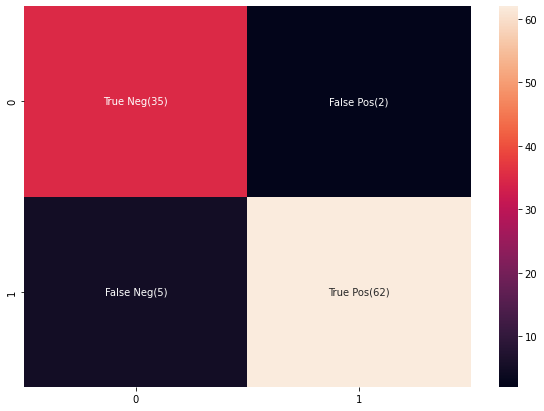

For Tree 2:


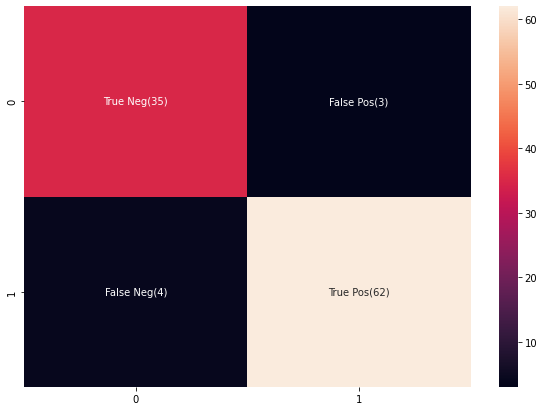

For Tree 3:


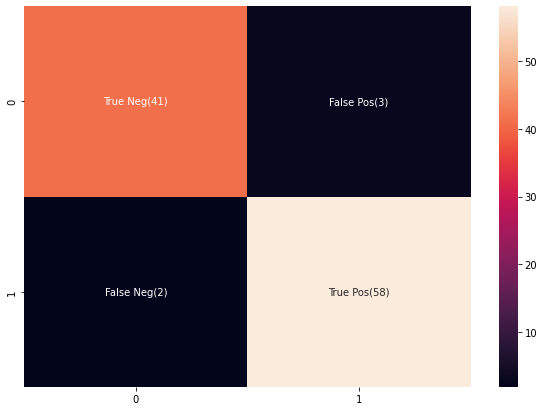

For Tree 4:


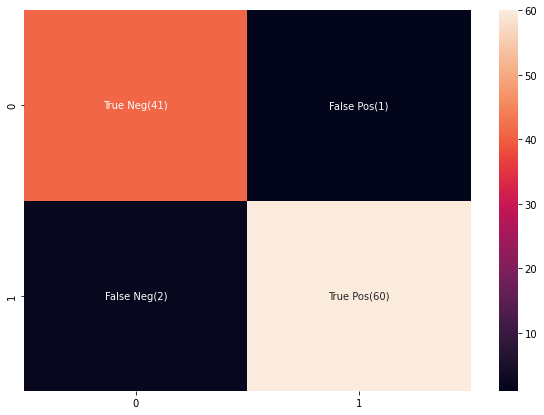

For Tree 5:


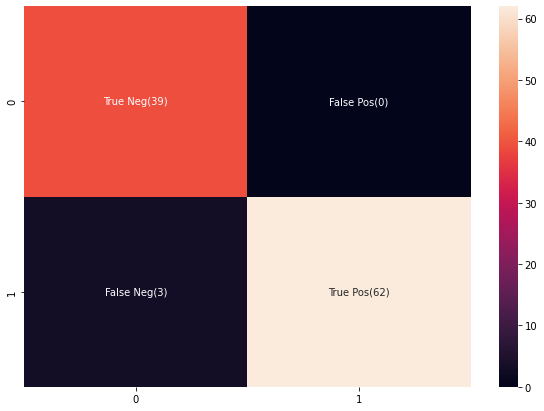

In [138]:
for index in range(len(conf_matrices)):
    print(f"For Tree {index+1}:")
    display_confusion_matrix(conf_matrices[index])

In [139]:
# run to see text based visualization for trees
def display_trees(trees, column_map):
    for index in range(len(trees)):
        print("*****************************")
        print(f"Tree {index+1}")
        tree = trees[index]
        tree.display_tree(tree.head, column_map)

### Error Analysis

Our best model among 5 different splits is last split on most cases.  

Our model works with an accuracy rate around 93%-96% even with test set. The high accuracy rate shows that our model works properly but for having better success metric, we have used precision, recall and f1 scores as stated in assignment pdf. According to high level of these metrics (can be seen above), we can say that our model works well even with test sets for 5 different splits. Also this indicates that the dataset has been carefully and consistently prepared and also shows that the number of outliers is low in our dataset (outliers can spoil model without pruning). 

Since we don't do pruning, our model is still slightly overfit (test-error > train-error), so post-pruning can increase metric scores even more. 